In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right
 
device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [18]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer_reduced/e4fa5153-fb94-4840-83f1-4515e28c6a4a/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [19]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'learnt_linear',
                            'gamma_min': -2.,
                            'gamma_max': 2.,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': False,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 150,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [20]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [21]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [22]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=dataset.get_scaler(),
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        ).to("cuda")

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

In [23]:
generative_model.device

device(type='cuda', index=0)

**Check the data**

In [24]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [25]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [26]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

In [27]:
X_generated = generative_model.sample(batch_size=10000, 
                                         n_sample_steps=1000, 
                                         clip_samples=False,
                                         covariate="clusters")

sampling: 100%|██████████| 1000/1000 [00:06<00:00, 146.26it/s]


Analyze the results

Create adata and check plots

In [28]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [29]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [30]:
adata.obs["size_factor"] = adata.X.sum(1)

In [40]:
adata_original.X.sum(1)

matrix([[467.92618],
        [455.06387],
        [875.6751 ],
        ...,
        [274.8106 ],
        [251.62425],
        [220.27817]], dtype=float32)

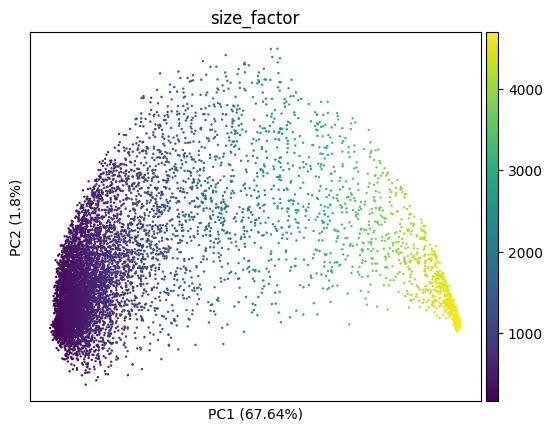

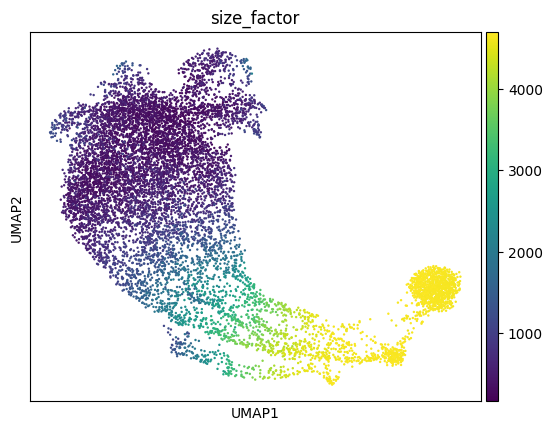

In [31]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

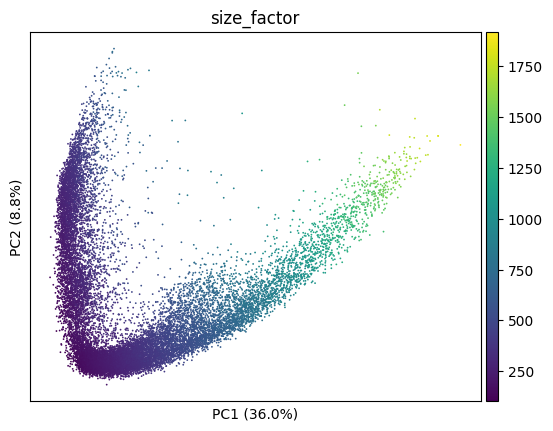

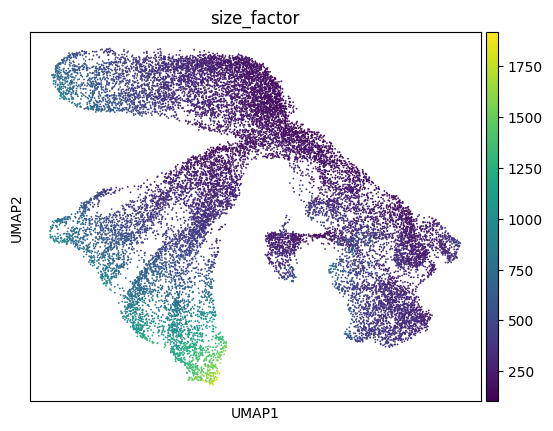

In [32]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

In [33]:
for i in generative_model.theta:
    print(i)

tensor(8.0222, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1199, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1495, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2127, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.4477, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2689, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(4.2277, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2213, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2623, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2178, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.5137, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1634, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.3076, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2537, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.0327, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.7486, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.6150, device='cuda:0', grad_fn=<UnbindBackward0

In [34]:
adata_original.X.sum(1)

matrix([[467.92618],
        [455.06387],
        [875.6751 ],
        ...,
        [274.8106 ],
        [251.62425],
        [220.27817]], dtype=float32)

In [35]:
adata.X.sum(1)

array([2592.7488 , 4621.872  ,  385.57098, ...,  336.47464,  649.3029 ,
       2017.9338 ], dtype=float32)

In [36]:
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=32,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

In [37]:
for batch in dataloader:
    x = batch["X_norm"]
    x_scaled = generative_model.scaler.scale(batch["X_norm"].to(generative_model.device), reverse=False)

In [23]:
x_scaled.min(1)

torch.return_types.min(
values=tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1.], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [41]:
def get_timestep_embedding(
    timesteps,
    embedding_dim: int,
    dtype=torch.float32,
    max_timescale=10_000,
    min_timescale=1,
):
    # Adapted from tensor2tensor and VDM codebase.
    assert timesteps.ndim == 1
    assert embedding_dim % 2 == 0
    timesteps *= 1000.0  # In DDPM the time step is in [0, 1000], here [0, 1]
    num_timescales = embedding_dim // 2
    inv_timescales = torch.logspace(  # or exp(-linspace(log(min), log(max), n))
        -np.log10(min_timescale),
        -np.log10(max_timescale),
        num_timescales,
        device=timesteps.device,
    )
    emb = timesteps.to(dtype)[:, None] * inv_timescales[None, :]  # (T, D/2)
    return torch.cat([emb.sin(), emb.cos()], dim=1)  # (T, D)